# <center> <img src="../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> **Big Data** </center>
---
### <center> **Autumn 2025** </center>
---
### <center> **Examples on Structured Streaming (Window-based aggregations)** </center>
---
**Profesor**: Pablo Camarillo Ramirez+

**Alumno**: Juan Alonso


# Create SparkSession

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on Structured Streaming (Kafka)") \
    .master("spark://spark-master:7077") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.13:4.0.0") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("INFO")

# Optimization (reduce the number of shuffle partitions)
spark.conf.set("spark.sql.shuffle.partitions", "5")

:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /root/.ivy2.5.2/cache
The jars for the packages stored in: /root/.ivy2.5.2/jars
org.apache.spark#spark-sql-kafka-0-10_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-c9fd3423-16a6-41cd-b0ab-0072537e81ee;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.13;4.0.0 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.13;4.0.0 in central
	found org.apache.kafka#kafka-clients;3.9.0 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.7 in central
	found org.slf4j#slf4j-api;2.0.16 in central
	found org.apache.hadoop#hadoop-client-runtime;3.4.1 in central
	found org.apache.hadoop#hadoop-client-api;3.4.1 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.scala-lang.modules#scala-parallel-collections_2.13;1.2.0

# Create a data stream from a Kafka topic

In [2]:
# Create the remote connection
kafka_df = spark.readStream \
            .format("kafka") \
            .option("kafka.bootstrap.servers", "kafka:9093") \
            .option("subscribe", "topic-juan-1") \
            .load()

kafka_df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [3]:
from pyspark.sql.functions import explode, split, window
input_df = kafka_df.withColumn("value_str",
                               kafka_df.value.cast("string"))

input_df = input_df.select("value_str", "timestamp")

words = input_df.select(explode(split(input_df.value_str, " ")).alias("word"), "timestamp")

In [4]:
# The watermark allows late data to update the state within 2 minutes.
# Late data beyond the 2-minute threshold will be dropped.

windowd_counts = words \
                .withWatermark("timestamp", "2 minutes") \
                .groupBy(window(words.timestamp,
                                "30 seconds",
                                "15 seconds"),
                                words.word) \
                .count()

query_count = windowd_counts.writeStream \
        .trigger(processingTime='2 seconds') \
        .outputMode("complete") \
        .format("console") \
        .option("truncate", "false") \
        .start()

query_count.awaitTermination(300)

25/10/18 04:35:10 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-4b1e715f-1908-491d-81e3-d29ccfed0b1a. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
25/10/18 04:35:10 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


-------------------------------------------
Batch: 0
-------------------------------------------
+------+----+-----+
|window|word|count|
+------+----+-----+
+------+----+-----+



25/10/18 04:35:16 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 2000} milliseconds, but spent 5996 milliseconds
25/10/18 04:35:26 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 2000} milliseconds, but spent 2780 milliseconds


-------------------------------------------
Batch: 1
-------------------------------------------
+------------------------------------------+----+-----+
|window                                    |word|count|
+------------------------------------------+----+-----+
|{2025-10-18 04:35:15, 2025-10-18 04:35:45}|Hola|1    |
|{2025-10-18 04:35:00, 2025-10-18 04:35:30}|Hola|1    |
+------------------------------------------+----+-----+



-------------------------------------------
Batch: 2
-------------------------------------------
+------------------------------------------+------+-----+
|window                                    |word  |count|
+------------------------------------------+------+-----+
|{2025-10-18 04:35:00, 2025-10-18 04:35:30}|Mi    |1    |
|{2025-10-18 04:35:00, 2025-10-18 04:35:30}|Carlos|1    |
|{2025-10-18 04:35:00, 2025-10-18 04:35:30}|Juan  |1    |
|{2025-10-18 04:35:00, 2025-10-18 04:35:30}|nombre|1    |
|{2025-10-18 04:35:15, 2025-10-18 04:35:45}|nombre|1    |
|{2025-10-18 04:35:15, 2025-10-18 04:35:45}|Hola  |1    |
|{2025-10-18 04:35:00, 2025-10-18 04:35:30}|Hola  |1    |
|{2025-10-18 04:35:00, 2025-10-18 04:35:30}|es    |1    |
|{2025-10-18 04:35:15, 2025-10-18 04:35:45}|es    |1    |
|{2025-10-18 04:35:15, 2025-10-18 04:35:45}|Mi    |1    |
|{2025-10-18 04:35:15, 2025-10-18 04:35:45}|Carlos|1    |
|{2025-10-18 04:35:15, 2025-10-18 04:35:45}|Juan  |1    |
+--------------------------------

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/opt/spark/python/lib/py4j-0.10.9.9-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/opt/spark/python/lib/py4j-0.10.9.9-src.zip/py4j/clientserver.py", line 535, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

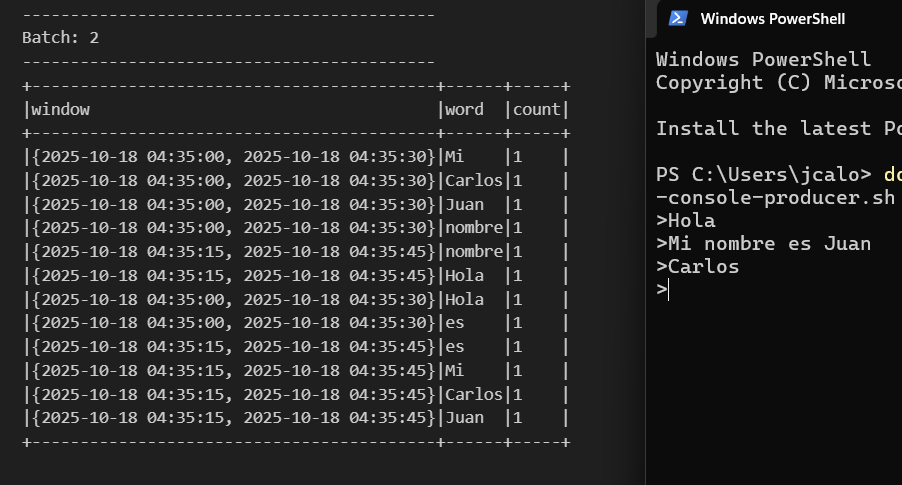

In [5]:
query_count.stop()

25/10/18 04:36:17 WARN DAGScheduler: Failed to cancel job group 6be09ce2-4970-4f95-a991-41017c7073fc. Cannot find active jobs for it.
25/10/18 04:36:17 WARN DAGScheduler: Failed to cancel job group 6be09ce2-4970-4f95-a991-41017c7073fc. Cannot find active jobs for it.


In [ ]:
# Create a new streaming query with another aggregation operation(avg, sum, min, or max)
from pyspark.sql.functions import count, max
windowd_max = words.groupBy("word") \
                .agg(
                    count("*").alias("count"),
                    max("timestamp").alias("latest_timestamp")
                )

query_max = windowd_max.writeStream \
        .trigger(processingTime='4 seconds') \
        .outputMode("complete") \
        .format("console") \
        .option("truncate", "false") \
        .start()

25/10/18 04:36:20 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-bd064e27-ac46-41a9-a53a-ad5d5f9f33c2. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
25/10/18 04:36:20 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


-------------------------------------------
Batch: 0
-------------------------------------------
+----+-----+----------------+
|word|count|latest_timestamp|
+----+-----+----------------+
+----+-----+----------------+

-------------------------------------------
Batch: 1
-------------------------------------------
+----+-----+-----------------------+
|word|count|latest_timestamp       |
+----+-----+-----------------------+
|mi  |1    |2025-10-18 04:36:26.739|
|es  |1    |2025-10-18 04:36:26.739|
|Este|1    |2025-10-18 04:36:26.739|
+----+-----+-----------------------+

-------------------------------------------
Batch: 2
-------------------------------------------
+-----------+-----+-----------------------+
|word       |count|latest_timestamp       |
+-----------+-----+-----------------------+
|Laboratorio|1    |2025-10-18 04:36:30.68 |
|mi         |1    |2025-10-18 04:36:26.739|
|es         |1    |2025-10-18 04:36:26.739|
|9          |1    |2025-10-18 04:36:30.68 |
|Este       |1    |2

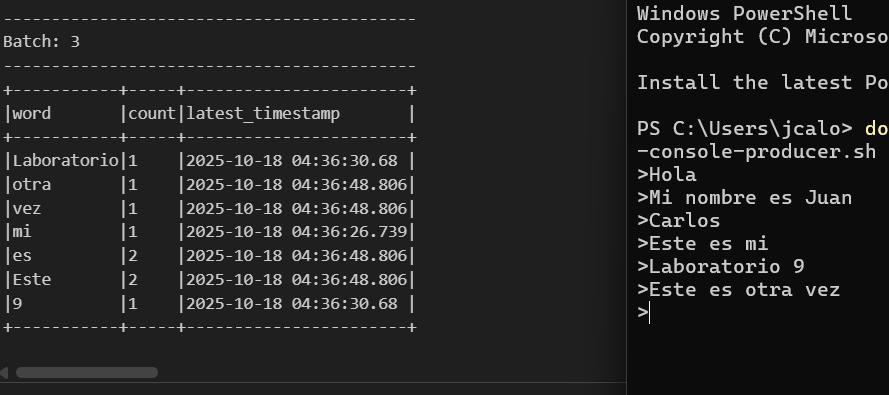

In [7]:
query_max.stop()

25/10/18 04:37:09 WARN DAGScheduler: Failed to cancel job group 2df02e6f-cab8-4ce7-b250-ef4029afb5e9. Cannot find active jobs for it.
25/10/18 04:37:09 WARN DAGScheduler: Failed to cancel job group 2df02e6f-cab8-4ce7-b250-ef4029afb5e9. Cannot find active jobs for it.


In [8]:
from pyspark.sql.functions import min
windowd_min = words.groupBy("word") \
                .agg(
                    count("*").alias("count"),
                    min("timestamp").alias("earliest_timestamp")
                )

query_min = windowd_min.writeStream \
        .trigger(processingTime='4 seconds') \
        .outputMode("complete") \
        .format("console") \
        .option("truncate", "false") \
        .start()

25/10/18 04:37:12 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-9fe88b2c-aa61-4eaa-b5bd-2ef4b8d01981. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
25/10/18 04:37:12 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


-------------------------------------------
Batch: 0
-------------------------------------------
+----+-----+------------------+
|word|count|earliest_timestamp|
+----+-----+------------------+
+----+-----+------------------+

-------------------------------------------
Batch: 1
-------------------------------------------
+-------+-----+-----------------------+
|word   |count|earliest_timestamp     |
+-------+-----+-----------------------+
|la     |1    |2025-10-18 04:37:18.464|
|min    |1    |2025-10-18 04:37:18.464|
|para   |1    |2025-10-18 04:37:18.464|
|es     |1    |2025-10-18 04:37:18.464|
|funcion|1    |2025-10-18 04:37:18.464|
|Este   |1    |2025-10-18 04:37:18.464|
+-------+-----+-----------------------+

-------------------------------------------
Batch: 2
-------------------------------------------
+-------+-----+-----------------------+
|word   |count|earliest_timestamp     |
+-------+-----+-----------------------+
|la     |1    |2025-10-18 04:37:18.464|
|min    |1    |2025

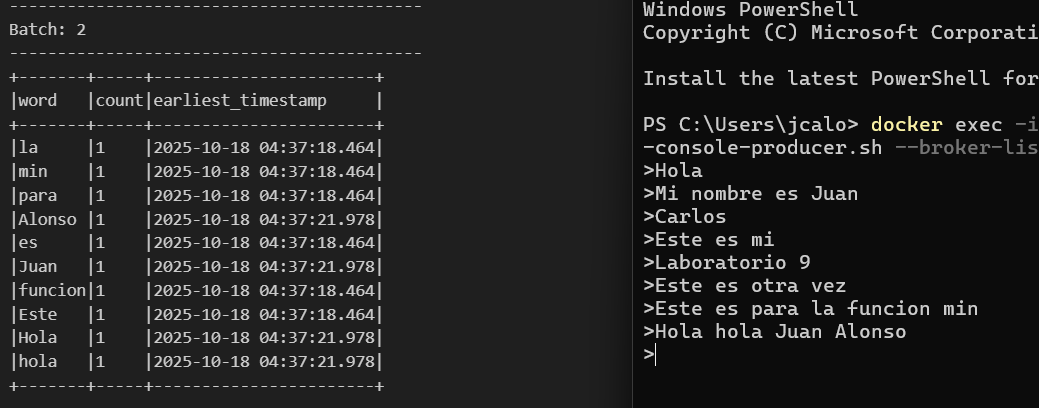

In [9]:
query_min.stop()

25/10/18 04:37:46 WARN DAGScheduler: Failed to cancel job group 5300c0cd-e381-42eb-b2ae-94faec0d03c4. Cannot find active jobs for it.
25/10/18 04:37:46 WARN DAGScheduler: Failed to cancel job group 5300c0cd-e381-42eb-b2ae-94faec0d03c4. Cannot find active jobs for it.


In [ ]:
from pyspark.sql.functions import sum, length

sum_agg = words.groupBy("word") \
        .agg(
            sum(length("word")).alias("total_characters"),
            count("*").alias("word_count")
        )

query_sum = sum_agg.writeStream \
        .trigger(processingTime='4 seconds') \
        .outputMode("complete") \
        .format("console") \
        .option("truncate", "false") \
        .start()

25/10/18 04:37:49 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-fd2a2d83-45e0-410f-aeff-c31c5f81cff5. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
25/10/18 04:37:49 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


-------------------------------------------
Batch: 0
-------------------------------------------
+----+----------------+----------+
|word|total_characters|word_count|
+----+----------------+----------+
+----+----------------+----------+

-------------------------------------------
Batch: 1
-------------------------------------------
+-----+----------------+----------+
|word |total_characters|word_count|
+-----+----------------+----------+
|es   |2               |1         |
|Ahora|5               |1         |
|este |4               |1         |
+-----+----------------+----------+

-------------------------------------------
Batch: 2
-------------------------------------------
+-------+----------------+----------+
|word   |total_characters|word_count|
+-------+----------------+----------+
|la     |2               |1         |
|es     |2               |1         |
|de     |2               |1         |
|Ahora  |5               |1         |
|funcion|7               |1         |
|Para   |4 

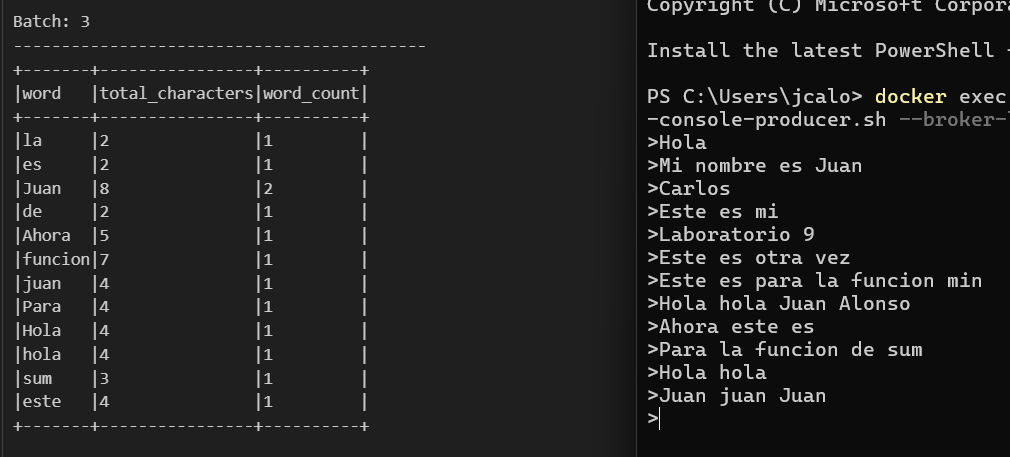

In [11]:
query_min.stop()

In [ ]:
from pyspark.sql.functions import avg, col

avg_agg = words.groupBy("word") \
        .agg(
            avg(col("timestamp").cast("long")).alias("avg_unix_timestamp") 
        ) \
        .select(
            col("word"),
            col("avg_unix_timestamp").cast("timestamp").alias("average_time")
        )

query_avg = avg_agg.writeStream \
        .trigger(processingTime='4 seconds') \
        .outputMode("complete") \
        .format("console") \
        .option("truncate", "false") \
        .start()

25/10/18 04:38:21 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-55c2b4b0-4f38-46a2-8120-cdeb47fbdfc3. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
25/10/18 04:38:21 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


-------------------------------------------
Batch: 0
-------------------------------------------
+----+------------+
|word|average_time|
+----+------------+
+----+------------+



-------------------------------------------
Batch: 4
-------------------------------------------
+-------+----------------+----------+
|word   |total_characters|word_count|
+-------+----------------+----------+
|la     |2               |1         |
|Juan   |8               |2         |
|de     |2               |1         |
|es     |2               |1         |
|Ahora  |5               |1         |
|Y      |1               |1         |
|ulitmo |6               |1         |
|funcion|7               |1         |
|juan   |4               |1         |
|Para   |4               |1         |
|Hola   |4               |1         |
|hola   |4               |1         |
|sum    |3               |1         |
|por    |3               |1         |
|este   |4               |1         |
+-------+----------------+----------+

-------------------------------------------
Batch: 1
-------------------------------------------
+------+-------------------+
|word  |average_time       |
+------+-----------------

-------------------------------------------
Batch: 5
-------------------------------------------
+-------+----------------+----------+
|word   |total_characters|word_count|
+-------+----------------+----------+
|la     |4               |2         |
|average|7               |1         |
|Juan   |8               |2         |
|de     |2               |1         |
|para   |4               |1         |
|es     |4               |2         |
|Ahora  |5               |1         |
|ulitmo |6               |1         |
|Y      |1               |1         |
|funcion|14              |2         |
|juan   |4               |1         |
|Para   |4               |1         |
|Hola   |4               |1         |
|Este   |4               |1         |
|hola   |4               |1         |
|sum    |3               |1         |
|por    |3               |1         |
|este   |4               |1         |
+-------+----------------+----------+

-------------------------------------------
Batch: 2
-------------

-------------------------------------------
Batch: 6
-------------------------------------------
+-------+----------------+----------+
|word   |total_characters|word_count|
+-------+----------------+----------+
|Average|7               |1         |
|la     |4               |2         |
|average|7               |1         |
|Juan   |8               |2         |
|de     |2               |1         |
|Averga |6               |1         |
|para   |4               |1         |
|es     |4               |2         |
|Ahora  |5               |1         |
|ulitmo |6               |1         |
|Y      |1               |1         |
|funcion|14              |2         |
|juan   |4               |1         |
|Para   |4               |1         |
|Hola   |12              |3         |
|Este   |4               |1         |
|hola   |8               |2         |
|este   |4               |1         |
|sum    |3               |1         |
|por    |3               |1         |
+-------+----------------+---

-------------------------------------------
Batch: 7
-------------------------------------------
+-------+----------------+----------+
|word   |total_characters|word_count|
+-------+----------------+----------+
|Average|7               |1         |
|la     |4               |2         |
|Averga |6               |1         |
|para   |4               |1         |
|Alonso |6               |1         |
|average|7               |1         |
|Juan   |12              |3         |
|de     |2               |1         |
|es     |4               |2         |
|Ahora  |5               |1         |
|ulitmo |6               |1         |
|Y      |1               |1         |
|funcion|14              |2         |
|juan   |4               |1         |
|Para   |4               |1         |
|Hola   |12              |3         |
|Este   |4               |1         |
|hola   |8               |2         |
|este   |4               |1         |
|sum    |3               |1         |
+-------+----------------+---

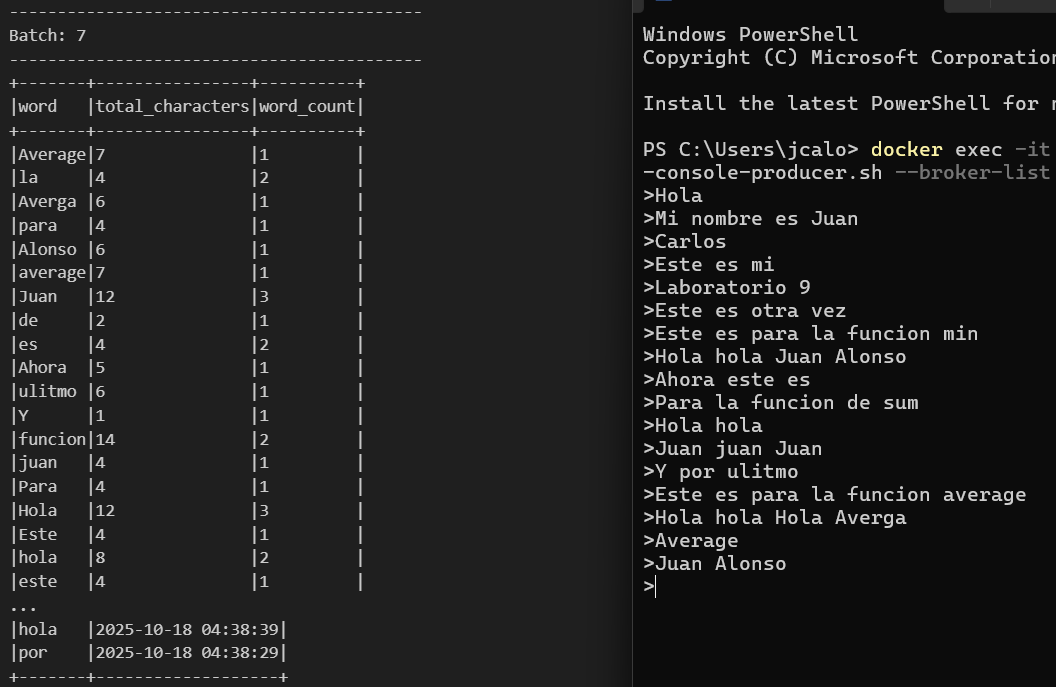

In [13]:
query_avg.stop()

25/10/18 04:39:08 WARN DAGScheduler: Failed to cancel job group 5a3e6b3a-cf08-4f58-bceb-32f71e24a937. Cannot find active jobs for it.
25/10/18 04:39:08 WARN DAGScheduler: Failed to cancel job group 5a3e6b3a-cf08-4f58-bceb-32f71e24a937. Cannot find active jobs for it.


In [14]:
sc.stop()

25/10/18 04:39:18 WARN JavaUtils: Attempt to delete using native Unix OS command failed for path = /tmp/temporary-9fe88b2c-aa61-4eaa-b5bd-2ef4b8d01981. Falling back to Java IO way
java.io.IOException: Failed to delete: /tmp/temporary-9fe88b2c-aa61-4eaa-b5bd-2ef4b8d01981
	at org.apache.spark.network.util.JavaUtils.deleteRecursivelyUsingUnixNative(JavaUtils.java:191)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:116)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:94)
	at org.apache.spark.util.SparkFileUtils.deleteRecursively(SparkFileUtils.scala:121)
	at org.apache.spark.util.SparkFileUtils.deleteRecursively$(SparkFileUtils.scala:120)
	at org.apache.spark.util.Utils$.deleteRecursively(Utils.scala:1048)
	at org.apache.spark.util.ShutdownHookManager$.$anonfun$new$4(ShutdownHookManager.scala:70)
	at org.apache.spark.util.ShutdownHookManager$.$anonfun$new$4$adapted(ShutdownHookManager.scala:67)
	at scala.collection.ArrayOps$.foreac